# Assignment 2: Image Matching and Face Detection
Author: Theodore Janson - 260868223 <br>
Course: ECSE 415 <br>
Date: October 19th, 2020 + Extension

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/ECSE 415/Assignment_2/'

#Make sure to restart runtime to use SIFT objects
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached https://files.pythonhosted.org/packages/a7/25/d4aa87bb9279127f1bac881b7524d8bafd25d626aba2c28fa355ed1ada2a/opencv_contrib_python-4.4.0.44-cp36-cp36m-manylinux2014_x86_64.whl


## 1 Invariance of SIFT Features
### 1.1 Invariance Under Changes of Scale

Compute SIFT Keypoints for reference image

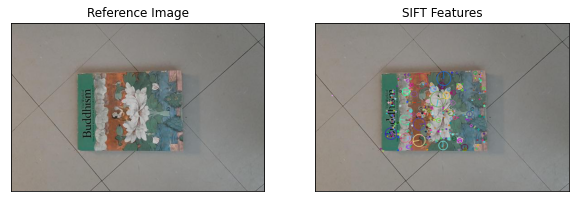

Number of keypoints 382


In [ ]:
import cv2

#Loading the book and making a copy to serve as reference
book = plt.imread(path+'book.jpg')
book_reference = book.copy()

#Creating SIFT object
sift = cv2.xfeatures2d.SIFT_create()
#Computing SIFT keypoints and their descriptors
keypoints1,descriptors1 = sift.detectAndCompute(book,None)
#Drawing keypoints onto image
cv2.drawKeypoints(book.copy(), keypoints1, book, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#display keypoints
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(book_reference)
plt.title("Reference Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(book)
plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()
print("Number of keypoints", len(keypoints1))


Scale reference images and compute key points. 

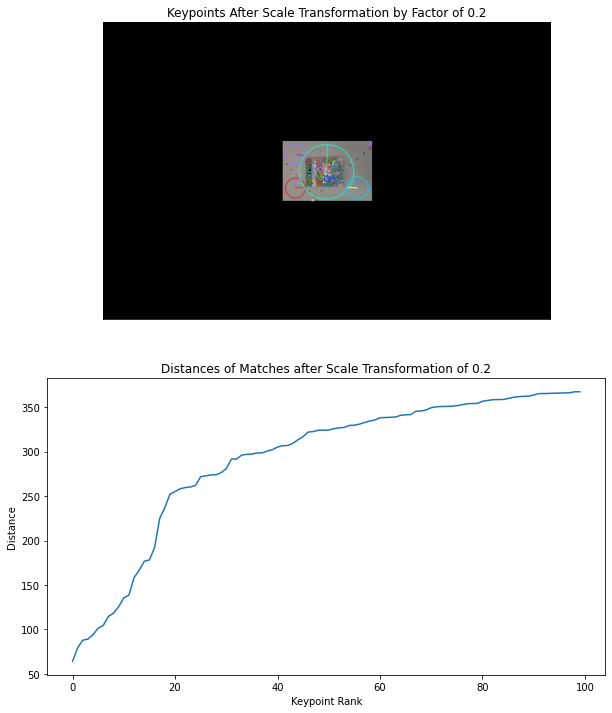

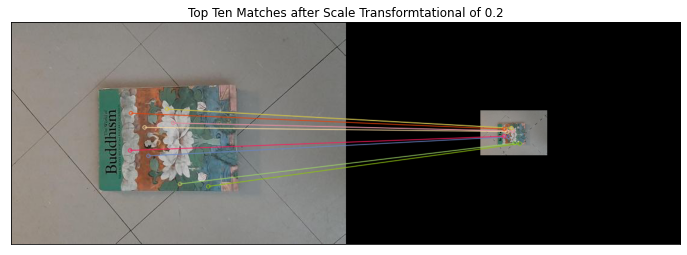

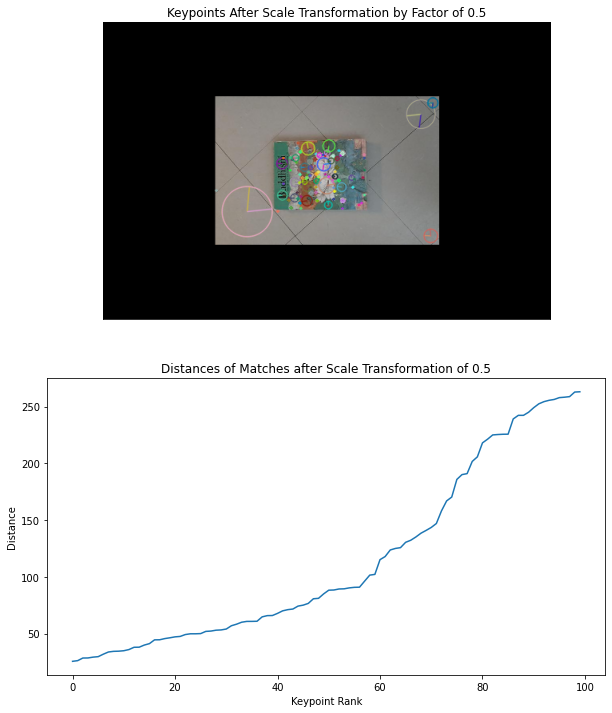

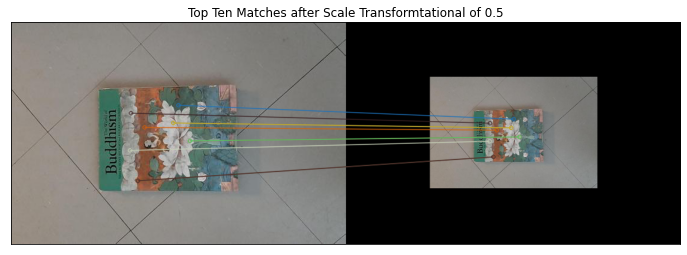

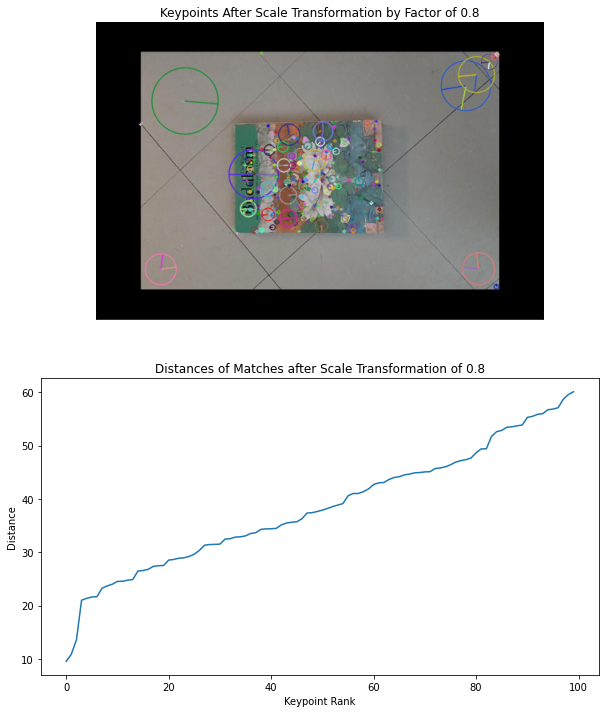

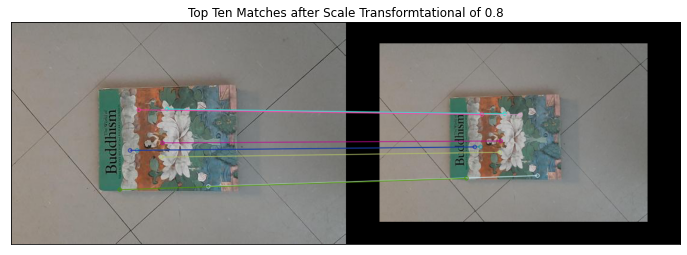

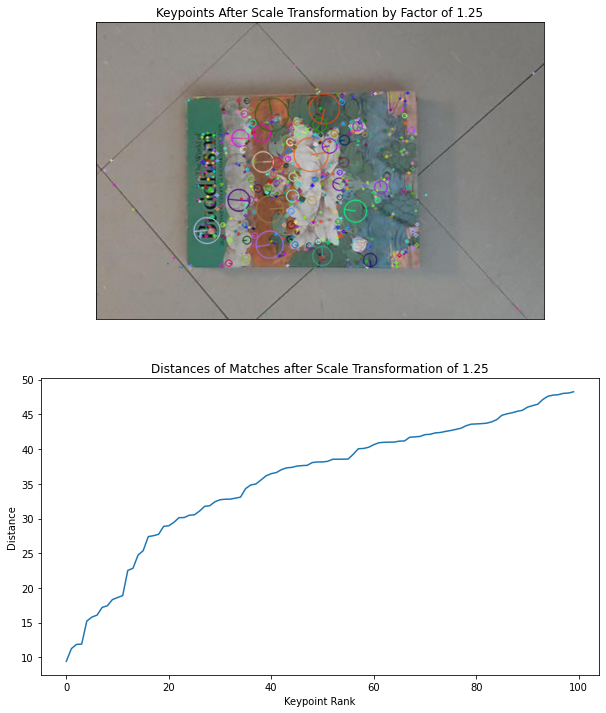

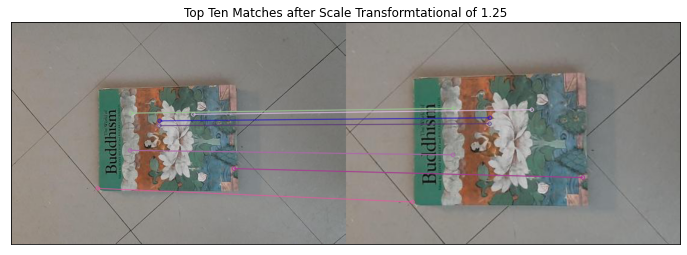

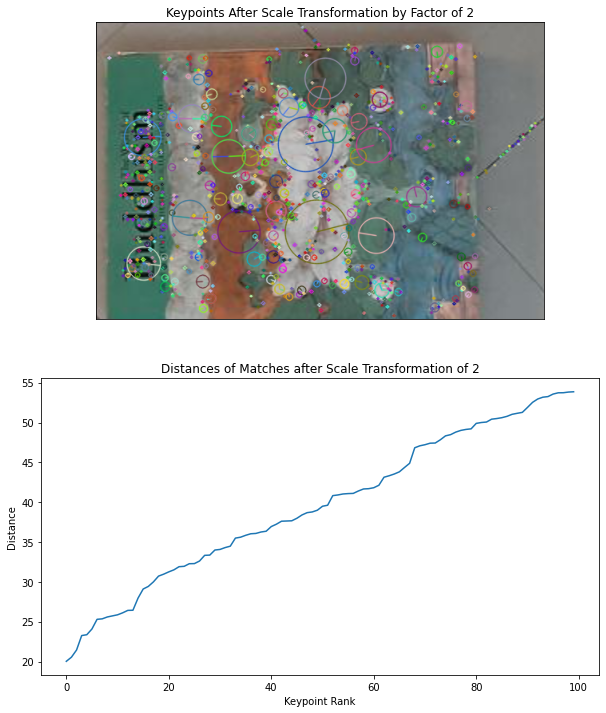

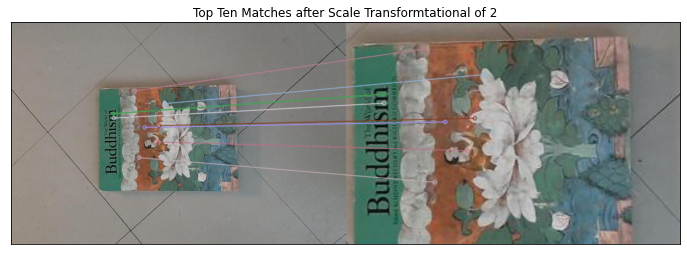

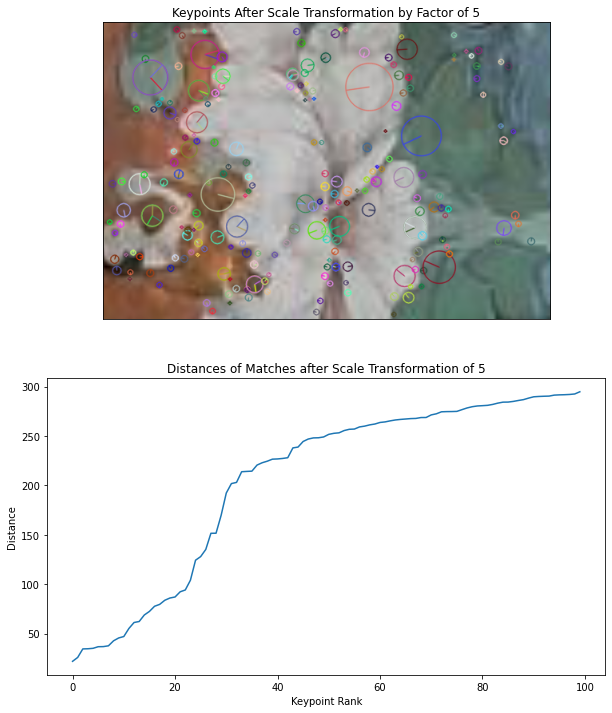

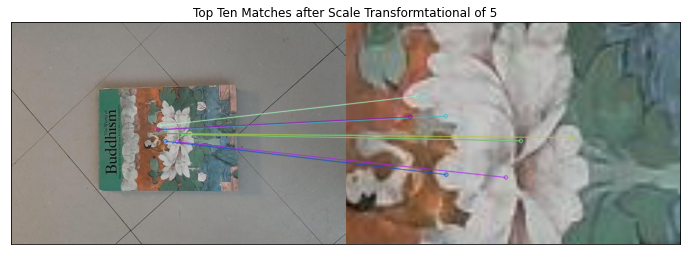

In [ ]:
"""
For a SIFT feature, displays the keypoints after a transformation, 
the best 10 feature matches between transformed image and reference
image, and displays the Euclidean distance between the top 100 descriptors
of the reference image and the transformed image. 
----------
keypoints : np.array image containing the keypoints after transformation
top_ten : np.array image containing the top ten matches
matches : list of top 100 matches 
transformation : string indicating the type of transformation
factor : transformation factor (float)
"""
def display(keypoints, top_ten, matches, transformation, factor):
  #Displaying image containing the keypoints after transformation
  plt.figure(figsize=(10,12))
  plt.subplot(211)
  plt.imshow(keypoints)
  plt.title('Keypoints After {} Transformation by Factor of {}'.format(transformation, factor))
  plt.xticks([]), plt.yticks([])

  #Displying Euclidean distance between top 100 features. 
  x,y = [],[]
  for i in range(100):
    x.append(i), y.append(matches[i].distance)
  plt.subplot(212)
  plt.plot(x, y)
  plt.xlabel("Keypoint Rank"), plt.ylabel("Distance")
  plt.title('Distances of Matches after {} Transformation of {}'.format(transformation, factor))
  plt.show()

  #Matching the top 10 features between transformed image and reference image. 
  plt.figure(figsize=(12,16))
  plt.subplot(111)
  plt.imshow(top_ten)
  plt.title('Top Ten Matches after {} Transformtational of {}'.format(transformation, factor))
  plt.xticks([]), plt.yticks([])
  plt.show()

"""
For every transformation factor for a scale or rotational transformation, 
find the transformation, apply it to the image. Then calculate the keypoints
and descriptors of transformed image, draw the keypoints onto the reference image. 
Match the best keypoints of the reference image and the transformed image and
calculate the Euclidean distance between their descriptors. Display the results 
----------
book_reference : reference image
factors : list of transformation factors
transformation : string indicating the type of transformation
"""
def keypoints_matches(book_reference,factors, transformation):

  sift = cv2.xfeatures2d.SIFT_create()
  #Computing SIFT keypoints and their descriptors
  keypoints1,descriptors1 = sift.detectAndCompute(book_reference,None)

  #declare dimensions of image
  y, x, z = book_reference.shape
  #iterating through the tranformation factors 
  for factor in factors: 
    #Apply the appropriate transformation
    if transformation == 'Scale':
      #Scale transformation centered at (x/2, y/2), no rotation and scale by factor
       M = cv2.getRotationMatrix2D((x/2,y/2),0,factor)
    else: 
      #Rotation transformation centered at (x/2, y/2), rotation by angle, scale of 1. 
      M = cv2.getRotationMatrix2D((x/2,y/2),factor,1)
    #Apply transformation
    transformed_img = cv2.warpAffine(book_reference,M,(x,y))
    #Take a copy of transformed image
    temp = transformed_img.copy()

    #Computing keypoints and descriptors for the transformed image
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints2,descriptors2 = sift.detectAndCompute(transformed_img,None)
    #Draw the keypoints onto the transformed image
    cv2.drawKeypoints(transformed_img.copy(), keypoints2, transformed_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    #Create brute force matching object 
    bf = cv2.BFMatcher()
    #Compute matches between reference image and transformed image
    matches = bf.match(descriptors1,descriptors2)
    #Sort the Euclidean distance between descriptors
    matches = sorted(matches, key = lambda x:x.distance)
    #Draw the top ten matches
    matched_keypoints_img = cv2.drawMatches(book_reference,keypoints1,temp,keypoints2, matches[:10], None, flags=2)
    #Display results
    display(transformed_img, matched_keypoints_img, matches, transformation, factor)

#Applying scale transformatiom with various factors
scale_factors = (0.2, 0.5, 0.8, 1.25, 2, 5)
keypoints_matches(book_reference,scale_factors, 'Scale')

###1.1.8 Discussion
By inspecting the plotted distances for the 100 best keypoints after various scale factors, we can clearly see that for the best keypoints, the distance between the keypoints descriptors of the original and transformed images decreasese as the scale factor increases. This is true up to a scale factor of 2, after which the distances increase again relative to the distance calculated for smaller scale transformations. 

Interestingly, the average distances seem to follow a positive parabolic trend. When the effect of the transformation is greatest (0.2 and 5 which are complementary transformations), the distance is greatest and the distance curves for those two transformations are similar. Likewise, the scale transformations of 0.8 and 1.25 have the similar relationship. However, the average distances of 2 and 0.5 are quite different. 

The distances may increase when the scale factor is above one because we are focusing on a smaller area of the image with fewer 'good' keypoints, as there are less options, which would make the distance of the best keypoints increase. 

Conversely, when the scale factor decreases below one, the keypoints become smaller and may be matched more ambiguously to keypoints in the original image which may contain many similar points. This would also increase the distance. 

## 1 Invariance of SIFT Features
### 1.2 Invariance Under Changes of Rotation

In [ ]:
#Applying rotational transformation with various angles
rotational_factors = (10, 30, 90, 150, 170, 180)
keypoints_matches(book_reference, rotational_factors, 'Rotation')


###1.2.8 Discussion
As displayed above, the effect of a rotational transformation by various angles has little effect on the average distance between the keypoint descriptors of the transformed image and the original image. Nevertheless, the effect is not negligeable. As the angle of rotation increases from 0 to 90, so does the distance between the keypoints, though not by much. The distance is maximised at a 90 degree rotational transformation and then decreases as the rotation continues to 180, at which a distance of 0 is reached, as it would be with 0 rotation. Clearly, the distances are also parabolic in nature, with a maximum at 90 degrees. 

The distance may increase at first because SIFT keypoints are not entirely invariant to rotational transformations, and each keypoints will look slightly different after a rotation, making the distance increase. The distance then drops down from a maximum at 90 degrees to 0 at 180 degrees because SIFT descriptors are invariant to mirroring transformations. 


## 2 Matching using SIFT - Book Reveal
### 2.1 Invariance Under Changes of Scale

In [ ]:
#Loading book
reference_book = cv2.imread(path+"book_crop.jpg")
#Loading Occluded book
occluded_book = cv2.imread(path+"book_occlusion.jpg")
#Making copies for reference
reference_book_ref = reference_book.copy()
occluded_book_ref = occluded_book.copy()
temp2 = occluded_book.copy()

#creating SIFT object
sift = cv2.xfeatures2d.SIFT_create()
#Computing keypoints and descriptors for occluded book
occl_keypoints,occl_descriptors = sift.detectAndCompute(occluded_book,None)
#Computing keypoints and descriptors for book
ref_keypoints, ref_descriptors = sift.detectAndCompute(reference_book,None)

#Drawing the keypoints onto the image 
cv2.drawKeypoints(reference_book_ref, ref_keypoints, reference_book, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(occluded_book_ref, occl_keypoints, occluded_book, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#Displaying Images and SIFT Features
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(occluded_book_ref)
plt.title("Occluded Book Reference"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(occluded_book)
plt.title("SIFT Features of Occluded Book"), plt.xticks([]), plt.yticks([])
plt.show()
print("Number of keypoints of Occluded Book", len(occl_keypoints))
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(reference_book_ref)
plt.title("Reference Book"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(reference_book)
plt.title("SIFT Features of Book"), plt.xticks([]), plt.yticks([])
plt.show()
print("Number of keypoints of Book", len(ref_keypoints))

#Creating Brute Force Matching Object
bf = cv2.BFMatcher()
#Matching keypoints between reference book and occluded book
matches = bf.match(ref_descriptors, occl_descriptors)
#Sorting these keypooints by Euclidean distance
matches = sorted(matches, key = lambda x:x.distance)
#Drawing the best 10 matches between reference book and occluded book
matches_img = cv2.drawMatches(reference_book_ref, ref_keypoints, occluded_book_ref, occl_keypoints, matches[:10], None, flags=2)

#plotting images
plt.figure(figsize=(30,20))
plt.subplot(111)
plt.imshow(matches_img)
plt.title('Best 10 Matched Keypoints'), plt.xticks([]), plt.yticks([])
plt.show()

# Arrange matching keypoints in two separate lists
best_matches = []
for i, m in enumerate(matches):
#Bound calculated by trial and error
  if m.distance < 200:
    best_matches.append((m.trainIdx, m.queryIdx))
best_occl = np.float32([occl_keypoints[i].pt for (i, __) in best_matches])
best_ref = np.float32([ref_keypoints[i].pt for (__, i) in best_matches])

# find homography and wrap image accordingly
H, _ = cv2.findHomography(best_ref, best_occl, cv2.RANSAC, 4)

yref, xref, zref = reference_book.shape
yoccl, xoccl, zoccl = occluded_book.shape
#Applying transformation
transformed_book_ref = cv2.warpPerspective(reference_book_ref, H, (xoccl, yoccl))

#Displaying results of best matches keypoints
plt.figure(figsize=(30,20))
plt.subplot(111)
plt.imshow(transformed_book_ref)
plt.title('Top Ten Matched Keypoints'), plt.xticks([]), plt.yticks([])
plt.show()

x, y, z = transformed_book_ref.shape

#Looping through rows and columns of transformed reference book and replacing 
#black pixels with occluded book image pixels. 
for row in range(x):
  for col in range(y):
    if (transformed_book_ref[row][col].any() != 0):
      temp2[row][col] = transformed_book_ref[row][col]


plt.figure(figsize=(30,20))
plt.subplot(111)
plt.imshow(temp2)
plt.title('Un-occluded image using SIFT and homography'), plt.xticks([]), plt.yticks([])
plt.show()



## 3 Face Detecton
### 3.1 Eigenface Representation

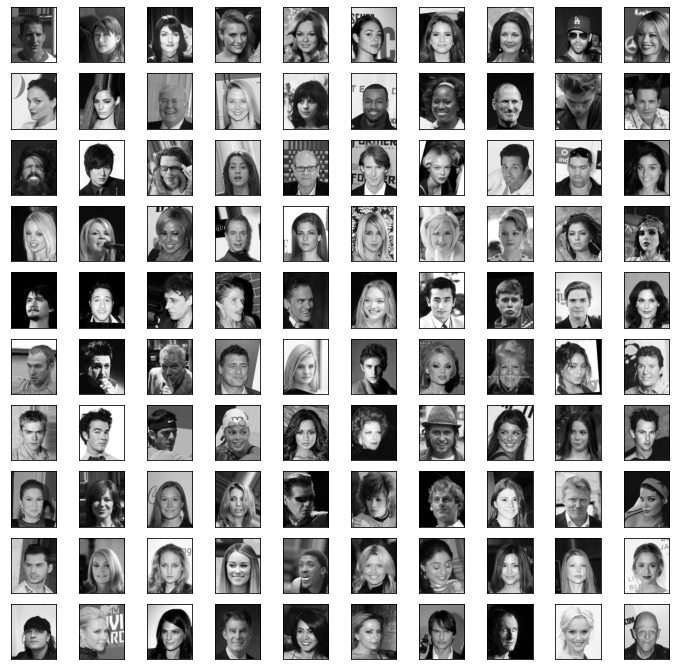

In [ ]:
import random
import os

dataset = os.listdir(path+'/celebA_subset/')
faces = []
indices = set() 
  
#creating list of 100 random indices
#note: since indices are a set, each index is unique
while len(indices) < 100 :
  indices.add(random.randint(0,1000))

#creating list of 100 random celebrity faces
for i in indices:
  face = cv2.imread(path+'/celebA_subset/'+dataset[i])
  face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
  faces.append(face)

#displaying faces
fig = plt.figure(figsize=(12,12)) 
for k in range(len(faces)): 
  fig.add_subplot(10, 10, k+1)
  plt.imshow(faces[k], cmap='gray')
  plt.xticks([]), plt.yticks([])
plt.show()



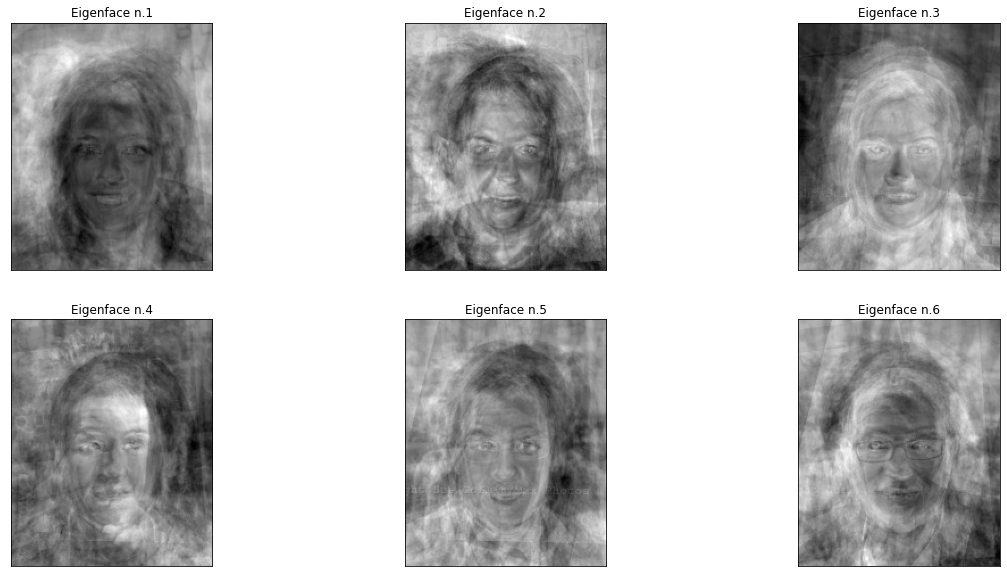

In [ ]:
#dimensions of face images (each image has same dimensions in dataset)
rows, cols = faces[0].shape

#creating D matrix with 100 image vectors (dim: image size , 100)
D = []
for face in faces: 
  D.append(face.flatten())
D = np.array(D)
#Taking transpose because flatten creates row vector out of array
D = np.transpose(D) 

#Computing average face matrix
avg_face = D.mean(axis=1)
avg_matrix = []
#Take average over every column 
for i in range(D.shape[1]):
  avg_matrix.append(avg_face)
avg_matrix = np.array(avg_matrix)
avg_matrix = avg_matrix.transpose()

#Compute difference between array of vector faces and average face
A = D - avg_matrix 

#compute covariance matrix of this difference
covariance = np.cov(np.transpose(A))
#find eigenvalues and eigenvectors of covariance matrix 
eigenvalues, eigenvectors = np.linalg.eig(covariance) 

#sort eigenvectors in descending order of associated eigenvalue size 
eigenvectors = [eigenvectors for _,eigenvectors in sorted(zip(eigenvalues,eigenvectors), reverse = True)]
eigenvalues = sorted(eigenvalues, reverse = True)

#slice for the eigenvectors associated with the k largest eigenvalues
k=6
k_eigenvectors = np.array(eigenvectors[0:k])
#compute eigenfaces for these k eigenvectors
eigenfaces = k_eigenvectors.dot(np.transpose(A))
#and matrix of associated weights for each eigenface
weights = np.transpose(A).dot(np.transpose(eigenfaces))
#displaying k eigenfaces
eigen_disp = []
plt.figure(figsize=(20, 10))
for i in range(k):
    eigenface = eigenfaces[i]
    eigenface = eigenface.reshape(rows, cols)
    plt.subplot(2,3,i+1), plt.imshow(eigenface, cmap = 'gray')
    plt.title('Eigenface n.{}'.format(i+1))
    plt.xticks([]), plt.yticks([])
plt.show()


k=100
k_eigenvectors = np.array(eigenvectors[0:k])
#compute eigenfaces for these k eigenvectors
eigenfaces = k_eigenvectors.dot(np.transpose(A))
weights = np.transpose(A).dot(np.transpose(eigenfaces))



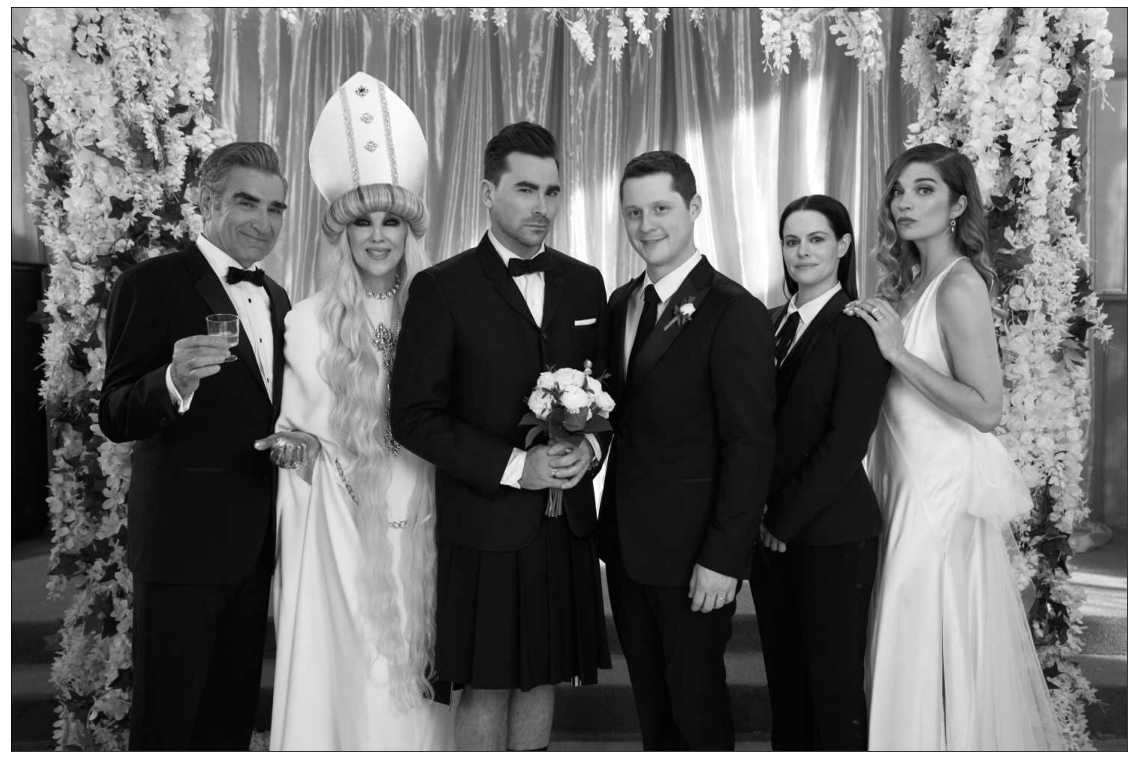

In [ ]:
#Loading group image and graying
group = cv2.imread(path+"schitt's_creek_group_photo.jpeg")
group = cv2.cvtColor(group, cv2.COLOR_BGR2GRAY)

#Parameters for window sliding
step = 10 #step size
window_y = 120 #window height
window_x = 100 #window width
threshold = 100000000 #threshold for face detection 

#Iterating over the rows and columns of the image by step size
#Only iterating over the area of the image containing faces to improve runtime
for y in range(100, group.shape[0]-600, step):
  for x in range(250, group.shape[1]-250, step): 
    #at each step create window
    window = group[y:y + window_y, x:x + window_x]
    #resize window window to be the same size as average face computed in 3.1
    window = cv2.resize(window, (rows,cols), interpolation = cv2.INTER_AREA)
    #resize the window array into a column vector 
    window = (np.array(window.ravel()))
    #Taking difference with average face
    window = window - avg_face
    #dot product of window and difference between window and average face to get weight (or confidence)
    test_weight = np.transpose(window).dot(np.transpose(eigenfaces))
    #getting second order norm of difference between weights in window and weights of average face
    norm = np.linalg.norm(test_weight - weights, ord=2, axis=1)
    dist = min(norm)
    #thresholding the distance and revealing faces
    if (dist < threshold):
      group = cv2.rectangle(group, (x, y), (x + window_x, y + window_y), (255, 0, 0), 3)


fig=plt.figure(figsize=(20, 24))
plt.subplot(111), plt.imshow(group, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.show()




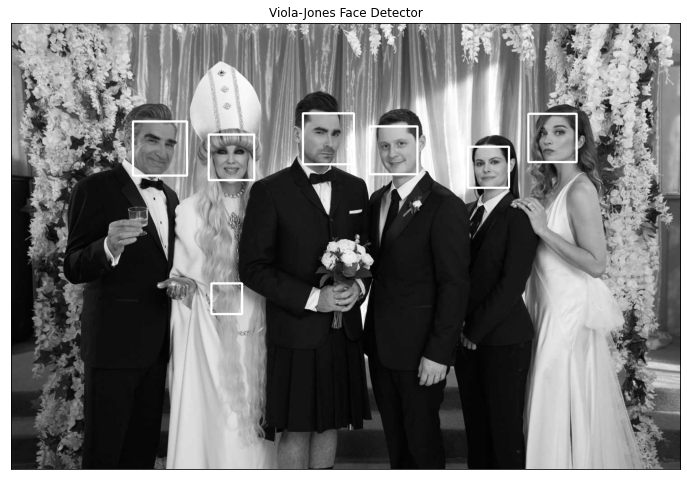

In [ ]:
group2 = cv2.imread(path+"schitt's_creek_group_photo.jpeg")
group2 = cv2.cvtColor(group2, cv2.COLOR_BGR2GRAY)

#creating haarcascade classifier object
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

#detecting face
faces = face_cascade.detectMultiScale(group2, 1.1,8)

#placing ractangles on faces
for (x,y,w,h) in faces:
    group2 = cv2.rectangle(group2,(x,y),(x+w,y+h),(255,0,0),3)

#Displaying
plt.figure(figsize=(12,20))
plt.subplot(111)
plt.imshow(group2, cmap="gray"),plt.xticks(()), plt.yticks(())
plt.title('Viola-Jones Face Detector'), plt.xticks([]), plt.yticks([])
plt.show()

###3.2 Discussion
The Viola Jones detector only detected one false positive, wheras my detector detected 7, though it should be noted that I constrained the sliding window area to a subsection of the image to improve runtime. 
Also, when i restart my runtime, I get different locations for face detection, which has be adjusting the threshold all the time. In my last iteration, a threshold of 17000000 detected 4 faces with 7 false positives. 

Had I slid the window over the entire image, I would have detected many more. Overall the method is not very effective, and really frustrated me. Because faces may be of varying sizes, using a single sized sliding window is not very effective. Moreover, if this method were to be used to count the number of faces in an image, it would not be effective because in addition to detecting false positives, it may detect true positives more than once due to the necessary small step size. 

I expect the Viola Jones detector to work better when there are faces of varying sizes, or when quick face detection is required such as in surveillance videos (though I am not too fond of that application) :)